# Raster-based geospatial analysis

This part of the course focuses on data following a [raster model](https://www.spatialanalysisonline.com/HTML/index.html?raster_models.htm). Please go through this whole [chapter on surface and field analysis](https://www.spatialanalysisonline.com/HTML/index.html?surface_and_field_analysis.htm) before proceeding.

Import a couple of libraries we are going to use:

In [3]:
import rasterio
import bokeh
import urllib.request
import zipfile
import os

Download and unzip a multi-layer [GeoTIFF](https://www.geospatialworld.net/article/geotiff-a-standard-image-file-format-for-gis-applications/), but **only** if it hasn't been downloaded and unzipped before:

In [5]:
if os.path.isfile('Africa.tif'):
    print("Africa.tif already downloaded and unzipped.")
else:
    urllib.request.urlretrieve("http://carsten.io/Africa.zip", "Africa.zip")
    zf = zipfile.ZipFile("Africa.zip")
    zf.extractall()
    zf.close()
    os.remove("Africa.zip") # clean up
    print("Download and unzip complete.")

Download and unzip complete.


Let's open the file with [rasterio](https://rasterio.readthedocs.io/en/latest/):

In [6]:
africa_tif = rasterio.open('Africa.tif')

Print some information about the dataset:

In [7]:
print("The file is called", africa_tif.name)
print()
print("It is", africa_tif.width, "x",africa_tif.height,"pixels big")
print()
print("It covers the following extent:",africa_tif.bounds)
print()
print("It is in the following CRS:",africa_tif.crs)

The file is called Africa.tif

It is 10663 x 10117 pixels big

It covers the following extent: BoundingBox(left=-25.360422329999892, bottom=-46.96575286299996, right=63.493907097000005, top=37.34520091400016)

It is in the following CRS: EPSG:4326


How many layers are there in this GeoTIFF, and what data types do they use?

In [8]:
{i: dtype for i, dtype in zip(africa_tif.indexes, africa_tif.dtypes)}

{1: 'int16', 2: 'int16', 3: 'int16', 4: 'int16'}

These four layers are:

1. [UN country ID](https://en.wikipedia.org/wiki/ISO_3166-1_numeric) for each cell.
2. Population per cell
3. Urban extents (urban cells have value 2, rural cells value 1)
4. Alpha layer, defining areas with no data

Let's take a look at the first three:

In [9]:
import matplotlib as mlp
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline 

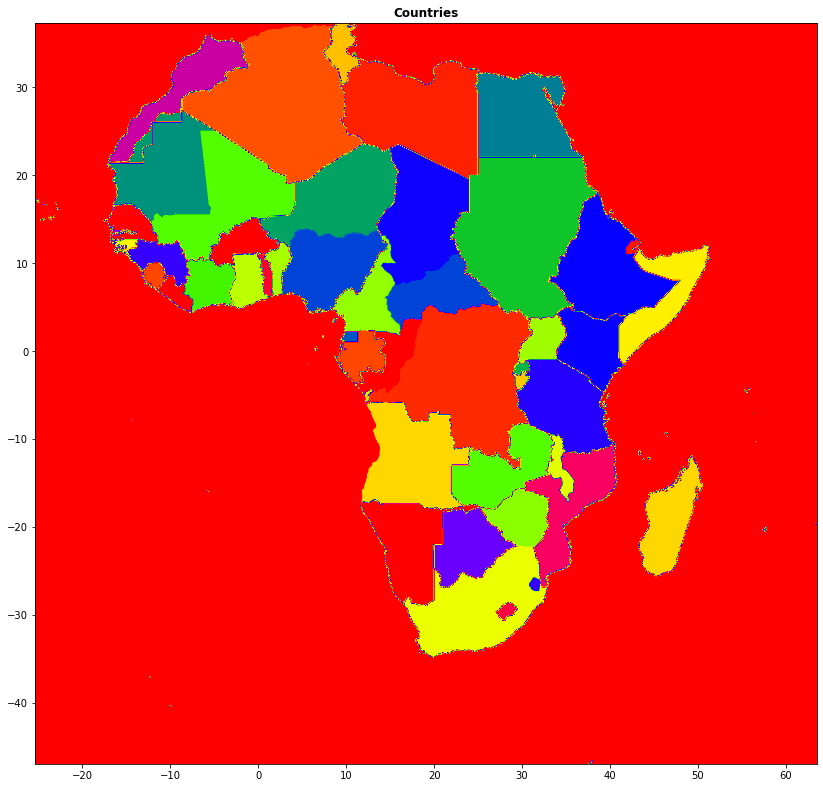

In [10]:
plt.figure(figsize=(14, 14))
show((africa_tif, 1), title='Countries', cmap='prism')

Let's jump to the urban areas (layer 3), shown in black in the following plot:

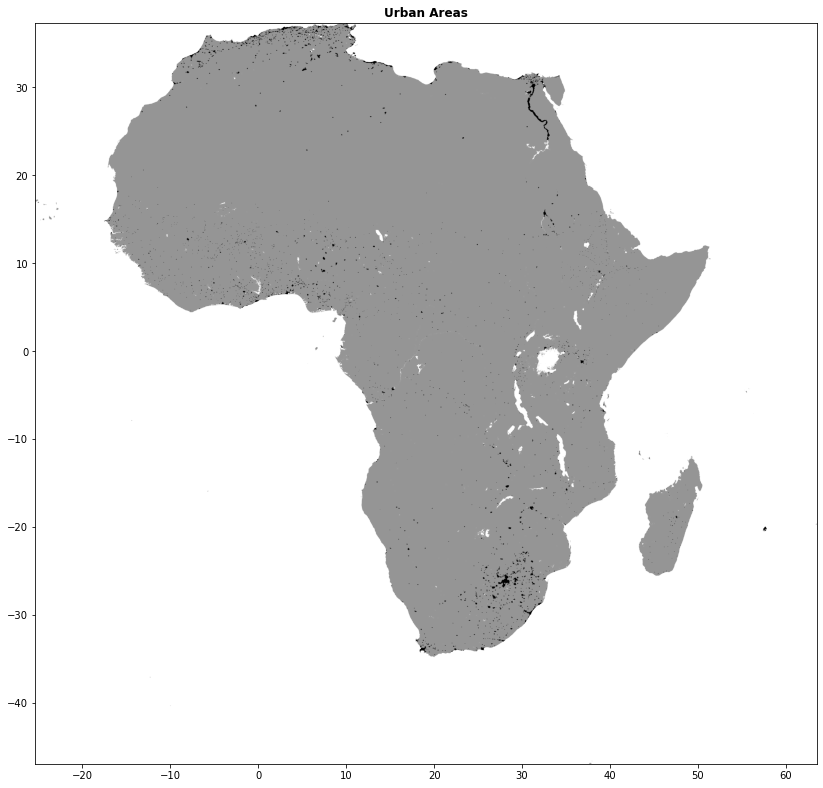

In [11]:
plt.figure(figsize=(14, 14))
show((africa_tif, 3), title='Urban Areas', cmap='Greys')

And finally, population:

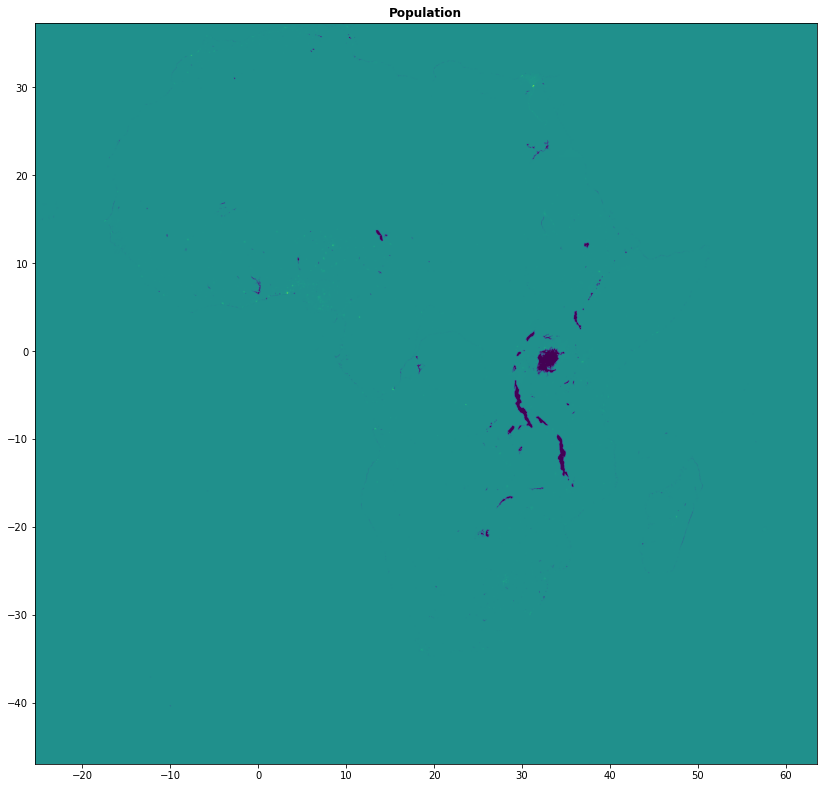

In [12]:
plt.figure(figsize=(14, 14))
show((africa_tif, 2), title='Population')

Not great, let's try to improve this by (1) using a different [colormap](https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html) and (2) using a [logarithmic mapping](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.colors.LogNorm.html) of the population values to the color scale. The logarithmic mapping helps to better show the differences among the less densely populated areas. With the standard linear mapping, only the super densely populated areas pop out and it looks like the rest of the continent is uninhabited. 

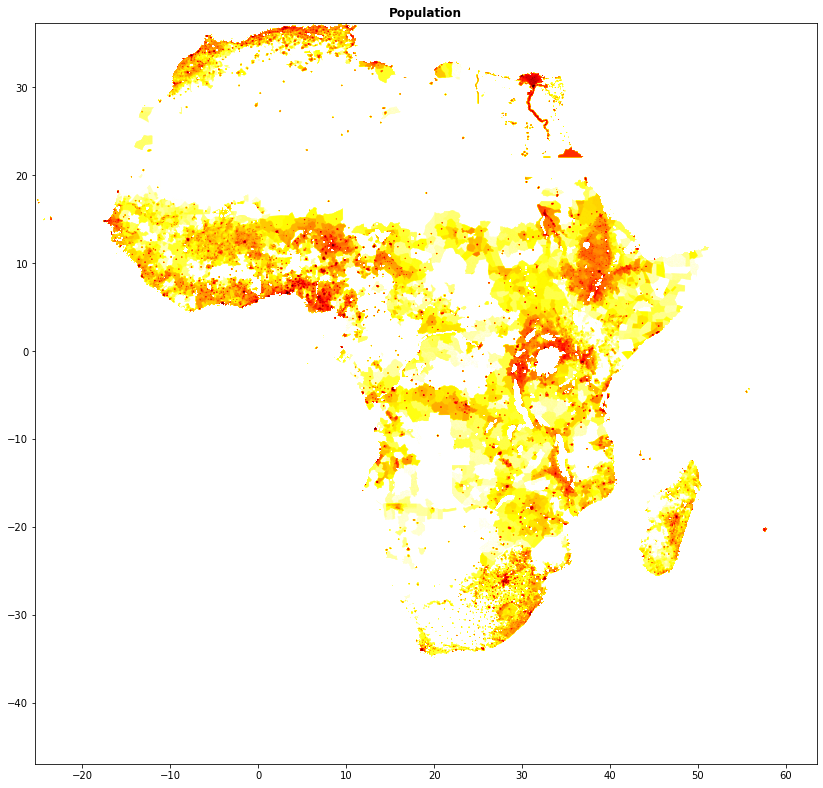

In [80]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(14, 14))
show((africa_tif, 2), title='Population', norm=LogNorm(), cmap='hot_r')

Can we add a legend?

In [81]:
pop = africa_tif.read(2)

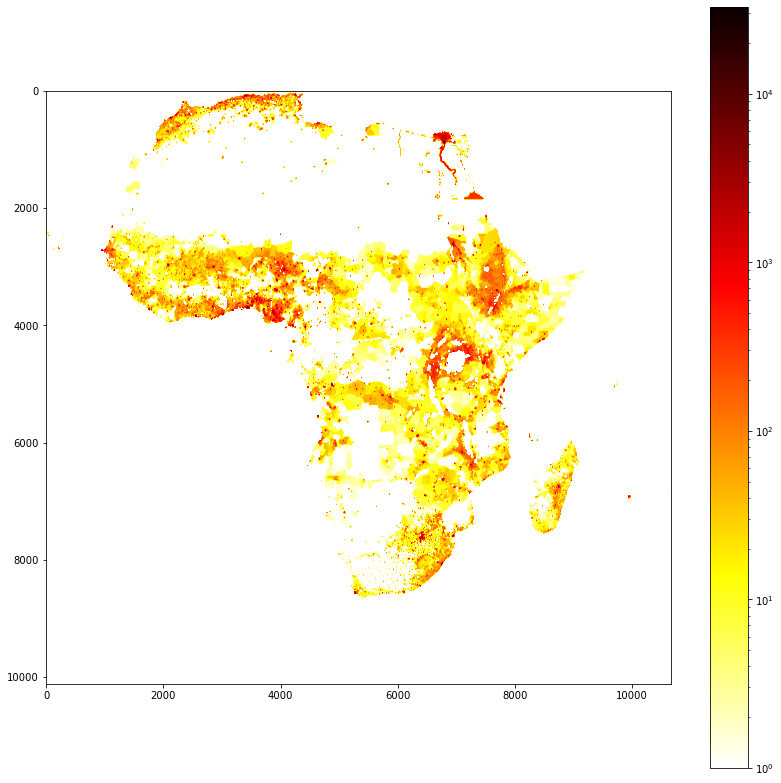

In [82]:
plt.figure(figsize=(14, 14))

imgplot = plt.imshow(pop, norm=LogNorm(), cmap='hot_r')
plt.colorbar()

These are just static maps, though. A good alternative, especially during data exploration, is the generation of  interactive plots with [Bokeh](https://docs.bokeh.org/en/latest/index.html):

In [83]:
#import numpy as np
import bokeh.plotting as bkplt

Bokeh needs to know the size of the image to plot it correctly:

In [86]:
pop.shape

(10117, 10663)

The GeoTIFF layer for the Africa population is quite large, so this takes a short while to generate. The plot will open in a new window:

In [85]:
p = bkplt.figure(x_range=(0, pop.shape[0]), y_range=(0, pop.shape[1]))

# must give a vector of image data for image parameter
p.image(image=[pop], x=0, y=0, dw=pop.shape[0], dh=pop.shape[1], palette="Spectral11")

bkplt.show(p)

Bokeh can also make web maps:

In [87]:
from bokeh.tile_providers import get_provider, Vendors

# range bounds supplied in web mercator coordinates
p = bkplt.figure(x_range=(-2000000, 6000000), y_range=(-1000000, 7000000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(get_provider(Vendors.CARTODBPOSITRON))

bkplt.show(p)

# Compression

Raster formats for geospatial data can quickly become very large. If we adopt the datatypes carefully to the contained information and apply compression techniques such as [LZW compression](https://www.geeksforgeeks.org/lzw-lempel-ziv-welch-compression-technique/), we can reduce the file sizes significantly.

☝🏻 Note that we only consider [lossless compression](https://en.wikipedia.org/wiki/Lossless_compression) here. Lossy compression, as you may know it from blurry JPEG images or bad-sounding audio at low bit rates, would alter our data. There fore lossy compression is generally only used with areal imagery in the GIS context, if at all.

Let's define a function for GeoTIFF compression using [rasterio's environment configuration](https://rasterio.readthedocs.io/en/latest/api/rasterio.env.html). The function will convernt a `layer` from an `inputfile` to an `outputfile` with a provided `compression` algorithm and convert the data to the specified `datatype`:

In [88]:
def compress(inputfile, outputfile, layer, compression, datatype):
    
    with rasterio.Env():

        # Write an array as a raster band to a new 8-bit file. For
        # the new file's profile, we start with the profile of the source
        profile = inputfile.profile

        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=datatype,
            count=1,
            compress=compression)

        with rasterio.open(outputfile, 'w', **profile) as dst:
            dst.write(layer.astype(datatype), 1)

Now we'll use this function to take our population layer for Africa and save it in three different ways: 

1. With no compression as 32-bit floating point numbers
2. With LZW compression as 32-bit floating point numbers
3. With LZW compression as 32-bit integer numbers

There is really no reason to store population counts as floating point numbers, since there are no half people. So the last option would be the best without losing any information. 

In [89]:
compress(africa_tif, 'pop-float.tif',     pop, None, rasterio.float32)
compress(africa_tif, 'pop-float-lzw.tif', pop, 'lzw', rasterio.float32)
compress(africa_tif, 'pop-int-lzw.tif',   pop, 'lzw', rasterio.int32)

Take a look at the file sizes of the output files – quite the difference! Due to the large numbers of population in some of the cells, we have to use `int32` as data type. However, the urban layer only contains 1s and 2s, so let's do the urban layer to test int8:

In [90]:
urban = africa_tif.read(3)
compress(africa_tif, 'urban-int-lzw.tif', urban, 'lzw', rasterio.int8)

Only 2.5MB, even though we have the same number of cells as in the `pop-float.tif`, which is 431MB. 

Conclusion: If you work a lot with raster files, it is worth taking a minute to think about how to store the data (datatypes and compression).

# Map Algebra

*Map algebra basically involves doing math with maps.* If you have not come across Map Algebra yet, take a look at [this chapter](https://mgimond.github.io/Spatial/map-algebra.html) and [this article](https://gisgeography.com/map-algebra-global-zonal-focal-local/).

In [91]:
import seaborn as sns  # wrapper for matplotlib to make nice plots, in our case of the rasters   
from scipy import signal  # for the focal function
from skimage import graph # can do least cost

We'll use a small fake dataset here to demonstrate what the different kinds of functions do. Let's define two layers, let's say one is ground elevation, the other one is the height of vegeation above ground:


In [92]:
elevation = np.array([ [ 1, 1, 3, 4, 4, 2],
                       [ 1, 3, 4, 4, 2, 1],
                       [ 1, 2, 2, 3, 2, 0],
                       [ 1, 1, 2, 4, 0, 0]])

building = np.array([ [0, 1, 1, 1, 1, 2],
                       [ 1, 1, 1, 1, 1, 1],
                       [ 0, 1, 2, 3, 4, 0],
                       [ 0, 1, 0, 1, 0, 0]])

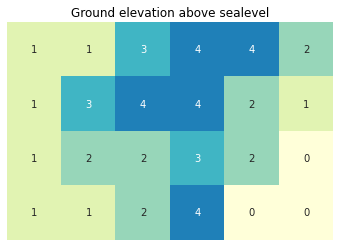

In [93]:
fig = sns.heatmap(elevation, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cmap="YlGnBu", cbar=False, vmin=0, vmax=6).set_title('Ground elevation above sealevel')

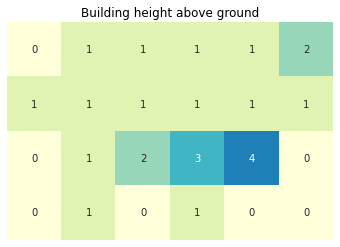

In [94]:
fig = sns.heatmap(building, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Building height above ground')

### 1. Local operation: Calculate building height above sea level

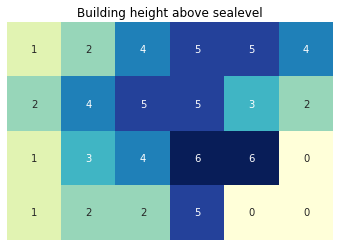

In [95]:
building_above_sealevel = elevation + building

fig = sns.heatmap(building_above_sealevel, 
                  annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Building height above sealevel')

### 2. Focal operation: Fix errors in elevation raster

Let's assume our elevation raster has a measurement error, e.g. because a bird flew under the LiDAR, so one pixel has  a too high value:

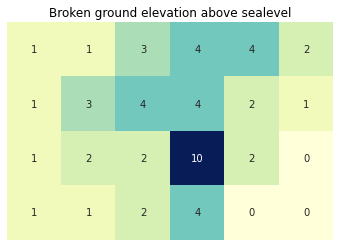

In [96]:
broken_elevation = elevation
broken_elevation[2,3] = 10

fig = sns.heatmap(broken_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Broken ground elevation above sealevel')

We'll fix this by running a 3x3 window over it that sets every pixel to the average of it's 8 neighbors:

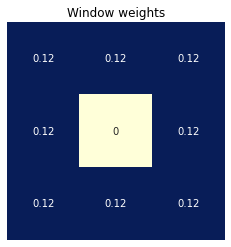

In [97]:
window = np.array([ [ 1/8., 1/8., 1/8.,],
                    [ 1/8., 0, 1/8.,],
                    [ 1/8., 1/8., 1/8.,],])

fig = sns.heatmap(window, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Window weights')

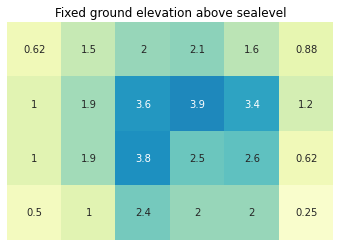

In [98]:
fixed_elevation = signal.convolve(broken_elevation, window, mode="same") # "moving window" function

fig = sns.heatmap(fixed_elevation, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu", vmin=0, vmax=6).set_title('Fixed ground elevation above sealevel')

Note that functions like this one always affect **all cells** (not just the "broken" one) and have **edge effects**!

## 3. Zonal operation: Average vegetation height per zone

Let's define two zones and calculate the average vegetation height per zone:

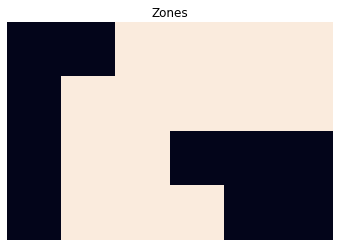

In [99]:
zones = np.array([ [0, 0, 1, 1, 1, 1],
                   [0, 1, 1, 1, 1, 1],
                   [0, 1, 1, 0, 0, 0],
                   [0, 1, 1, 1, 0, 0]])

fig = sns.heatmap(zones, square=True, xticklabels=False, yticklabels=False, cbar=False).set_title('Zones')

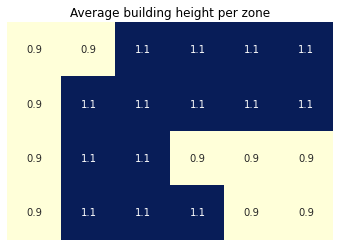

In [100]:
avg_veg_height = np.copy(zones).astype(float)

for zone in np.unique(zones):
    avg_veg_height[zones == zone] = np.mean(building[zones == zone])
    
fig = sns.heatmap(avg_veg_height, annot=True, cmap="YlGnBu", square=True, xticklabels=False, yticklabels=False, 
                  cbar=False).set_title('Average building height per zone')

## 4. Global operation: Cost distance

We'll use or elevation layer as a cost surface and calculate the cost to travel to each cell from a given start cell.

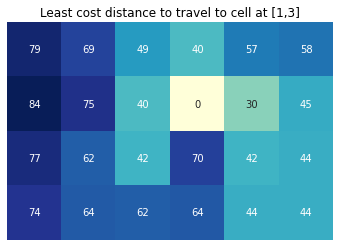

In [101]:
# turn our elevation into a cost surface
cellSize = 10
lg = graph.MCP_Geometric(elevation, sampling=(cellSize, cellSize))

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=[(1, 3)])[0]
fig = sns.heatmap(lcd, annot=True, square=True, xticklabels=False, yticklabels=False, 
                  cbar=False, cmap="YlGnBu").set_title('Least cost distance to travel to cell at [1,3]')

Calculate an example path, here from the top left pixel to our source, using [route_through_array](http://scikit-image.org/docs/0.7.0/api/skimage.graph.mcp.html#route-through-array)

In [102]:
from skimage.graph import route_through_array

In [103]:
route_through_array(elevation, [0, 1], [1, 3])

([(0, 1), (0, 2), (1, 3)], 6.949747468305833)

## Slope, aspect, and hillshade

Download [zoo.tif](https://www.dropbox.com/s/1w97ohqkcjgu2ku/zoo.tif?dl=0) for this part and put it in the same folder as the notebooks.

We have already used a small (fake) example of a digital elevation model (DEM) to illustrate some of the map algebra concepts. In this next block, we'll take a look at generating maps of [slope, aspect, and hillshade](https://www.spatialanalysisonline.com/HTML/index.html?gradient__slope_and_aspect.htm) from the pure elevation data.

We'll use the Python bindings for [GDAL](https://gdal.org), the Geospatial Data Abstraction Library, for that. GDAL is working in the background of many GIS programs and comes with a number of very useful tools that can be used from a command line interface or through Python, so make sure to take a close look at the GDAL documentation.

In [62]:
from osgeo import gdal

Take a look at the DEM:

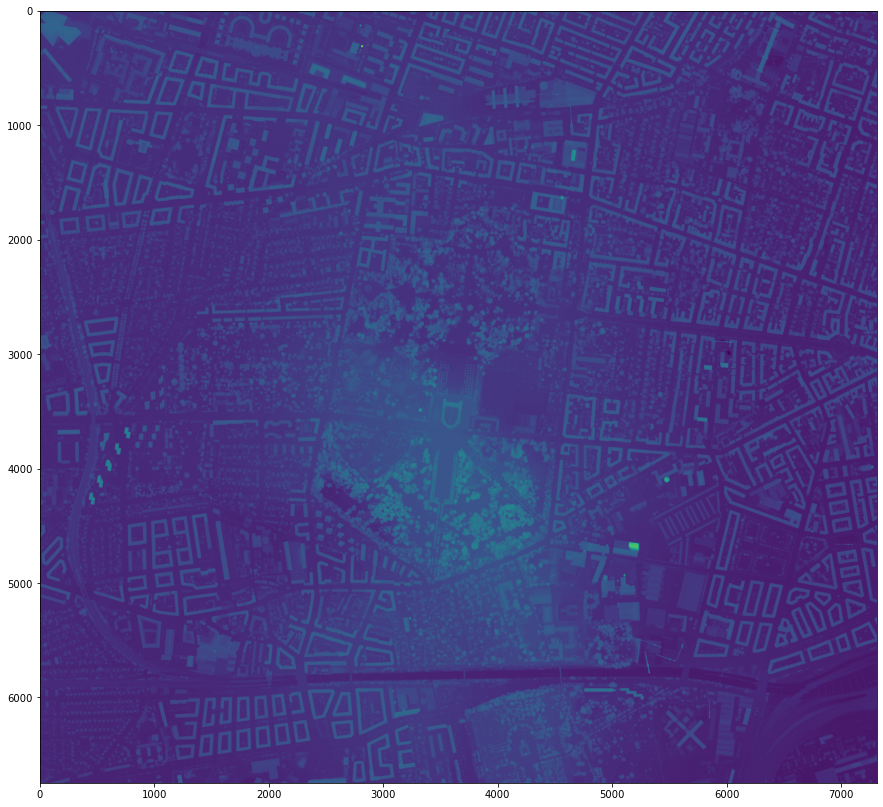

In [63]:
with rasterio.open('zoo.tif') as dataset:
    dem=dataset.read(1)
    plt.figure(figsize=(15, 15))
    imgplot = plt.imshow(dem)

We'll use the [DEMprocessing](https://gdal.org/python/osgeo.gdal-module.html#DEMProcessing) function in GDAL to calculate, slope, aspect, and hillshading:

slope surface for the Copenhagen Zoo area:
aspect surface for the Copenhagen Zoo area:
hillshade surface for the Copenhagen Zoo area:


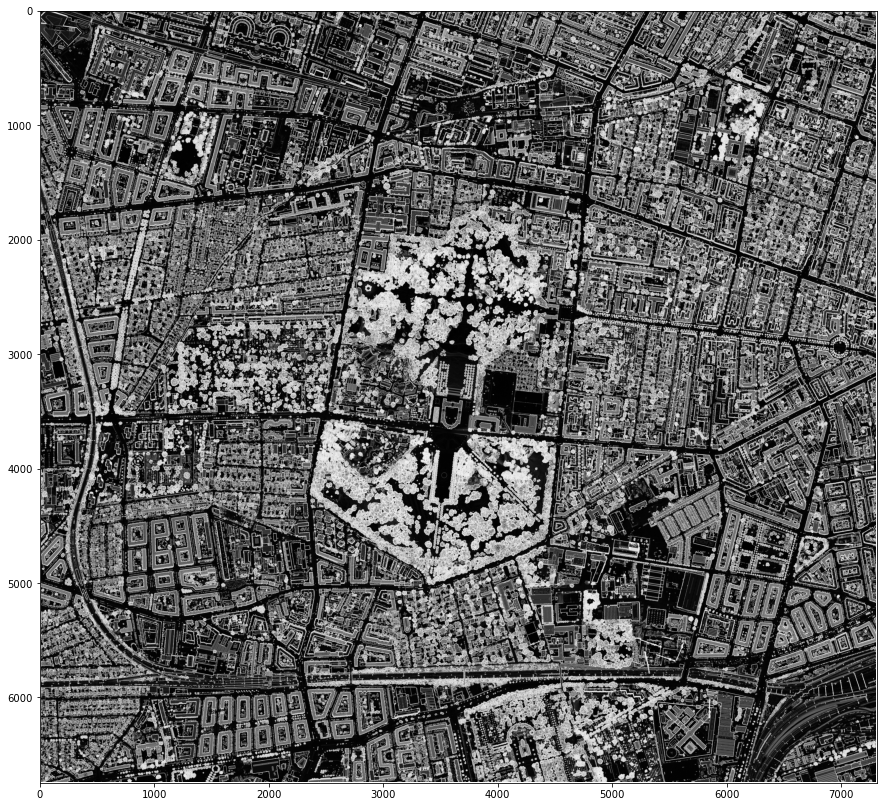

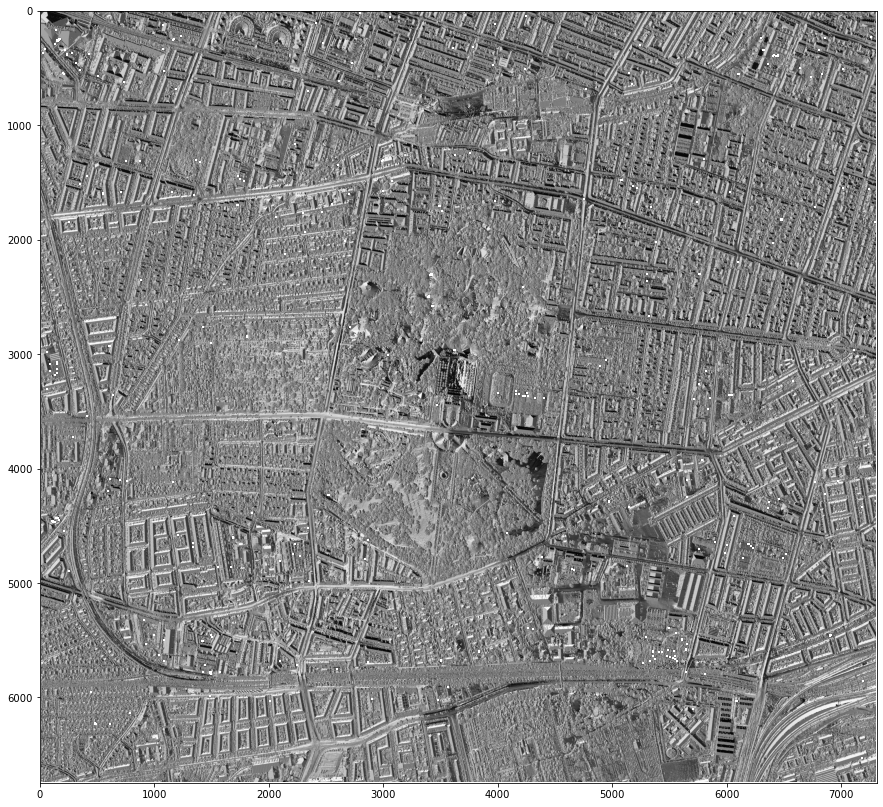

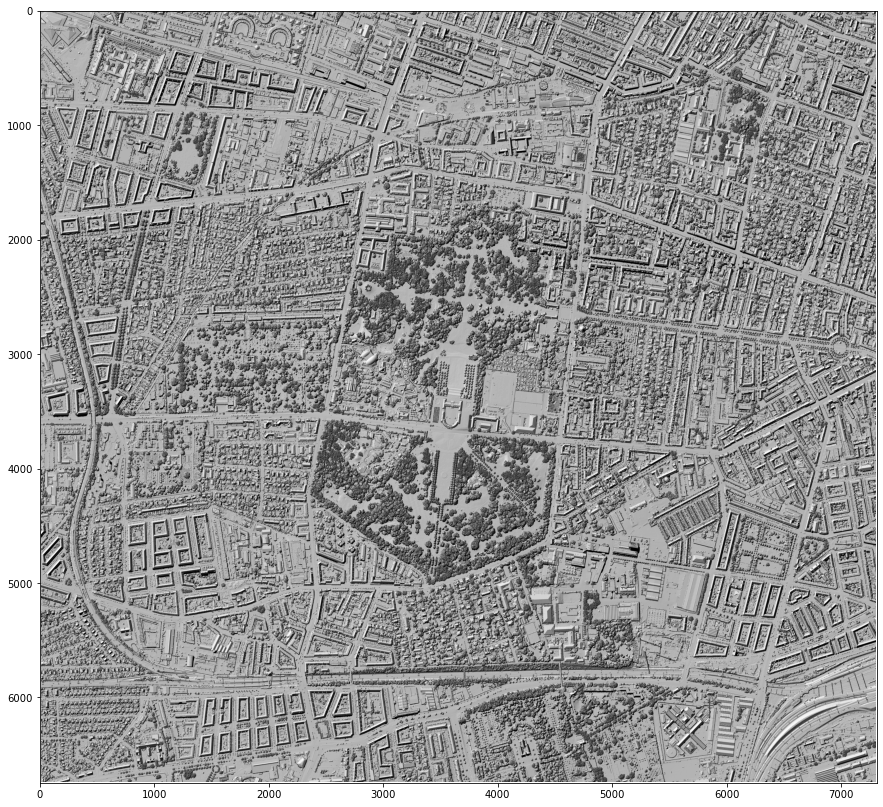

In [79]:
for f in ['slope', 'aspect', 'hillshade']:

    outfile = "zoo_"+f+".tif"
    gdal.DEMProcessing(outfile, "zoo.tif", f);  
    
    with rasterio.open(outfile) as dataset:
        dem=dataset.read(1, masked=True)
        plt.figure(figsize=(15, 15))
        imgplot = plt.imshow(dem, cmap='gray') # use a gray color palette instead of the standard yellow to blue

In [68]:
lg.find_costs(starts=urbanIndexes)

(array([[1956.16897322, 1955.16897322, 1954.16897322, ..., 3810.96168697,
         3811.96168697, 3812.96168697],
        [1955.75475966, 1954.75475966, 1953.75475966, ..., 3810.54747341,
         3811.54747341, 3812.54747341],
        [1955.3405461 , 1954.3405461 , 1953.3405461 , ..., 3810.13325985,
         3811.13325985, 3812.13325985],
        ...,
        [5865.02423794, 5864.02423794, 5863.02423794, ..., 3267.        ,
         3267.41421356, 3267.82842712],
        [5865.4384515 , 5864.4384515 , 5863.4384515 , ..., 3268.        ,
         3268.41421356, 3268.82842712],
        [5865.85266507, 5864.85266507, 5863.85266507, ..., 3269.        ,
         3269.41421356, 3269.82842712]]),
 array([[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [5, 5, 5, ..., 6, 7, 7],
        [3, 3, 3, ..., 6, 7, 7],
        [5, 5, 5, ..., 6, 7, 7]], dtype=int16))

# NumPy

![NumPy](https://numpy.org/_static/numpy_logo.png) 

*NumPy is the fundamental package for scientific computing with Python*. We have aready been using [NumPy](https://numpy.org) throghout this session in the background, without explicitly mentioning it. rasterio reads GeoTIFFs and them handles them internally as 2D-NumPy arrays, for example: 

In [104]:
pop

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

How many cells are in this layer?

In [45]:
pop.size

107877571

We have seen this one before – how many columns and rows do we have?

In [46]:
pop.shape

(10117, 10663)

In [105]:
pop.shape[0] * pop.shape[1]

107877571

Seems right :) One of the many cool things NumPy can do is the same kind of boolean indexing we have already seen with Pandas. We can easily ask for all cells with more than 1000 population, for example:

In [47]:
pop[pop > 1000]

array([1258, 1284, 1265, ..., 3198, 2527, 1315], dtype=int16)

... or cells in a certain country:

In [107]:
countries = africa_tif.read(1)
egypt = countries == 818 # = Egypt
egypt

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

... and we can combine such queries across layers – here we ask for the sum the population for all cells that are in Egypt:

In [108]:
np.sum(pop[egypt]) # what is happening here?

-108620901

Wait, what? Why is there negative population? That's because the population layer uses the value -9999 as a nodata value (for cells that are in the water). Let's fix that by setting them to zero:

In [109]:
pop[pop < 0] = 0

In [110]:
popegypt = np.sum(pop[egypt]) 
"{:,}".format(popegypt)

'81,662,875'

(In case you google the population of Egypt to double-check: The data is from 2010, so this is correct.)

Let's identify the urban and rural cells in Egypt:

In [111]:
cities = urban == 2
rural  = urban == 1

Now we can count them to calculate the number of urban and rural cells in Egypt (or any other country) in 2010:

In [112]:
urbanEgypt = np.all((egypt, cities), axis=0)
ruralEgypt = np.all((egypt, rural), axis=0)

When applied to boolean arrays, [np.sum](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.sum.html) treats ```True``` like 1 and ```False``` like 0:

In [113]:
print("Urban cells in Egypt:","{:,}".format(np.sum(urbanEgypt)))
print("Rural cells in Egypt:","{:,}".format(np.sum(ruralEgypt)))

Urban cells in Egypt: 33,689
Rural cells in Egypt: 1,267,349


## 🤔 Can we calculate the urban area from this?

... let's discuss during the Q&A!

# 🏋 Exercises

👉 **Calculate the *total* population and *urban* population for each country in Africa**

In [114]:
u = urban == 2

for c in np.unique(countries):
    
    incountry = countries == c
    
    print(c, "total:", "{:,}".format(np.sum(pop[incountry])))
    print(c, "urban:", "{:,}".format(np.sum(pop[np.all((incountry, u), axis=0)])))

0 total: 0
0 urban: 0
12 total: 38,615,393
12 urban: 23,453,970
24 total: 22,163,601
24 urban: 11,015,239
72 total: 2,422,366
72 urban: 1,226,879
108 total: 8,381,284
108 urban: 920,779
120 total: 22,517,640
120 urban: 11,312,845
132 total: 499,673
132 urban: 279,265
140 total: 4,532,869
140 urban: 1,701,565
148 total: 11,650,688
148 urban: 3,101,414
174 total: 681,595
174 urban: 199,135
178 total: 4,122,015
178 urban: 2,502,690
180 total: 67,391,405
180 urban: 22,773,233
204 total: 9,045,816
204 urban: 3,719,475
226 total: 1,147,244
226 urban: 256,952
231 total: 83,073,461
231 urban: 13,812,296
232 total: 5,206,923
232 urban: 1,099,901
262 total: 939,246
262 urban: 623,722
266 total: 1,961,972
266 urban: 1,222,524
270 total: 1,698,270
270 urban: 992,289
288 total: 25,099,168
288 urban: 12,494,757
324 total: 9,897,569
324 urban: 3,491,268
384 total: 20,213,177
384 urban: 9,457,883
404 total: 39,897,613
404 urban: 8,507,301
426 total: 2,171,319
426 urban: 583,629
430 total: 4,002,375
43

👉 **Generate a raster that indicates the distance to the closest urban cell for every cell in the output raster and visualize that raster**

First, pick out all the urban cells, which will be our source cells for the cost surface:

In [57]:
u = np.where(urban == 2)
u

(array([   1,    1,    1, ..., 8633, 8633, 8633]),
 array([4220, 4221, 4222, ..., 5364, 5365, 5371]))

Zip the two arrays to get the x and y positions of our urban source cells as a pair of indeces that we can pass on the the lest cost surface calculation:

In [58]:
urbanIndexes = [(x,y) for x,y in zip(u[0], u[1])]
urbanIndexes

[(1, 4220),
 (1, 4221),
 (1, 4222),
 (1, 4223),
 (2, 4219),
 (2, 4220),
 (2, 4221),
 (2, 4222),
 (2, 4223),
 (2, 4224),
 (2, 4225),
 (3, 4219),
 (3, 4220),
 (3, 4221),
 (3, 4222),
 (3, 4223),
 (3, 4224),
 (3, 4225),
 (4, 4218),
 (4, 4219),
 (4, 4220),
 (4, 4221),
 (4, 4222),
 (4, 4223),
 (4, 4224),
 (4, 4225),
 (5, 4217),
 (5, 4218),
 (5, 4219),
 (5, 4220),
 (5, 4221),
 (5, 4222),
 (5, 4223),
 (5, 4224),
 (5, 4225),
 (6, 4217),
 (6, 4218),
 (6, 4219),
 (6, 4220),
 (6, 4221),
 (6, 4222),
 (6, 4223),
 (6, 4224),
 (6, 4225),
 (7, 4216),
 (7, 4217),
 (7, 4218),
 (7, 4219),
 (7, 4220),
 (7, 4221),
 (7, 4222),
 (7, 4223),
 (7, 4224),
 (7, 4225),
 (8, 4217),
 (8, 4218),
 (8, 4219),
 (8, 4220),
 (8, 4221),
 (8, 4222),
 (8, 4223),
 (8, 4224),
 (8, 4225),
 (9, 4215),
 (9, 4216),
 (9, 4217),
 (9, 4218),
 (9, 4219),
 (9, 4220),
 (9, 4221),
 (9, 4222),
 (9, 4223),
 (9, 4224),
 (9, 4228),
 (9, 4229),
 (9, 4248),
 (9, 4249),
 (10, 4216),
 (10, 4217),
 (10, 4218),
 (10, 4219),
 (10, 4220),
 (10, 4221)

Make a "fake" cost surface where the cost for each cell is 1:

In [59]:
fake_cost = np.ones_like(pop)
fake_cost

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int16)

Calculate the cost surface:

In [60]:
lg = graph.MCP_Geometric(fake_cost)

# Calculate the least-cost distance from the start cell to all other cells
lcd = lg.find_costs(starts=urbanIndexes)[0]

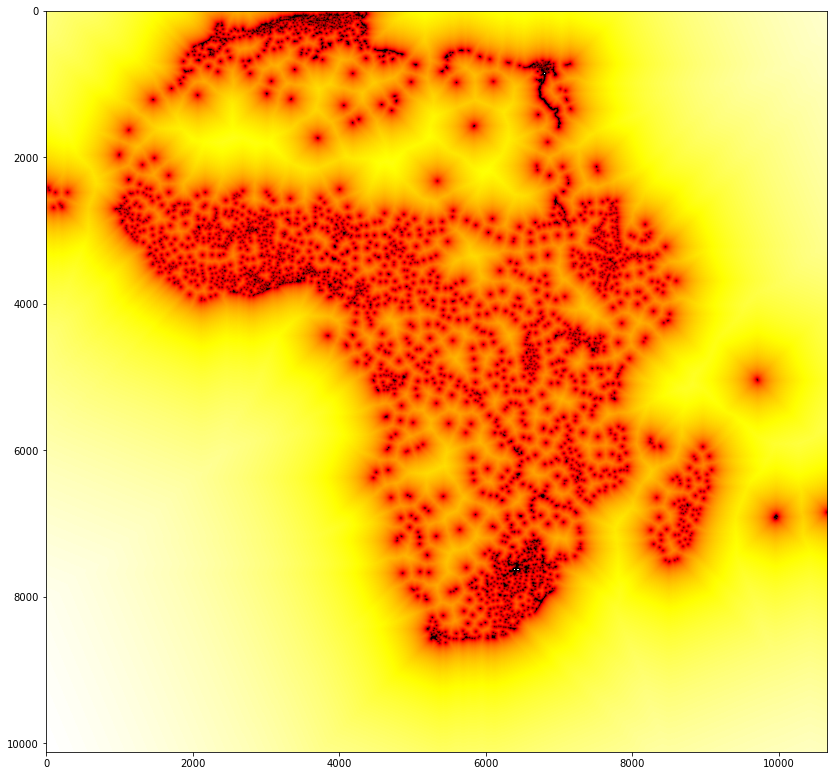

In [61]:
plt.figure(figsize=(14, 14))
imgplot = plt.imshow(lcd, norm=LogNorm(), cmap='hot')